In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from keras.models import Sequential, Model
from keras.layers import Dense, Conv3D, Conv2D, MaxPool3D, Flatten, LeakyReLU, Input, Dropout, BatchNormalization, Reshape, Resizing, Rescaling
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [2]:
data = np.load('images.npz')

# turns out subtracing 0.5 increases learning dramatically
X_image = np.array([np.array(Image.fromarray(image.astype(np.uint8)).convert('HSV')) for image in data['images']])
X = data['images']
y_image = Image.fromarray(data['colorschemes'].astype(np.uint8))
y_hsv_array = np.array(y_image.convert('HSV'))
print(y_hsv_array)
y = data['colorschemes']

[[[212  25  10]
  [ 61 151  94]
  [196  79 171]
  [ 33 126 247]]

 [[ 63 102  10]
  [206 111  64]
  [170 227 158]
  [195  10 240]]

 [[121 119  15]
  [ 15 194  97]
  [252 104 173]
  [ 20 106 227]]

 ...

 [[106  12  41]
  [115 132  79]
  [ 56 167 161]
  [137  91 250]]

 [[ 12  79  64]
  [ 91 222  87]
  [226 193 171]
  [216 160 194]]

 [[176  63  56]
  [163 210  92]
  [165 107 156]
  [ 61 126 191]]]


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

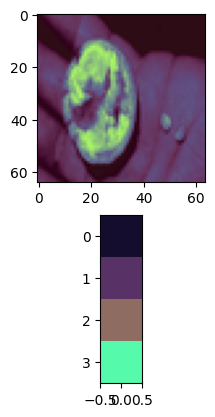

In [4]:
fig, axes = plt.subplots(nrows=2)
image_index = 13
axes[0].imshow(data['images'][image_index])
axes[1].imshow(data['colorschemes'][image_index].reshape(4, 1, 3))

In [5]:
class Sorting(keras.layers.Layer):
  def __init__(self, kernel_size):
    super().__init__()
    self.kernel_size = kernel_size
    self.w = self.add_weight(
        shape=kernel_size,
        initializer="ones",
        trainable=False
    )

  def call(self, inputs):
    sorted = tf.argsort(tf.reduce_sum(inputs * self.w, 2))
    rv = tf.gather(inputs, sorted, batch_dims=1)
    return rv

In [23]:
from keras.src.layers.normalization.batch_normalization_v1 import BatchNormalization
model = Sequential()
model.add(Resizing(64, 64))
#x = Conv3D(filters=1, kernel_size=(2, 2, 1), strides=(2, 2, 1), activation='relu')(input)
#x = MaxPool3D(pool_size = (2, 2, 1))(x)
model.add(Reshape((4096, 3)))
model.add(Sorting(kernel_size=3))
model.add(Resizing(1, 4))
# print(model.output_shape)
# output = Dense(12, activation='tanh')(x)
model.build(input_shape=(1, 64, 64, 3))
plot_model(model, 'png.png', show_layer_names=False, show_shapes=True)

early_stopping_condition = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


phi = (5**0.5) / 2 + 0.5
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', 'cosine_similarity'], loss_weights=[1, 4])
history = model.fit(X_train, y_train, epochs=1000, validation_split=0.2, callbacks=(early_stopping_condition))

Epoch 1/1000
34/34 [==============================] - 1s 20ms/step - loss: 3660.3047 - mean_squared_error: 3660.3047 - cosine_similarity: 0.9003 - val_loss: 4043.7212 - val_mean_squared_error: 4043.7212 - val_cosine_similarity: 0.8850
Epoch 2/1000
34/34 [==============================] - 0s 13ms/step - loss: 3962.2100 - mean_squared_error: 3962.2100 - cosine_similarity: 0.8845 - val_loss: 4043.7212 - val_mean_squared_error: 4043.7212 - val_cosine_similarity: 0.8850
Epoch 3/1000
34/34 [==============================] - 1s 15ms/step - loss: 3848.7876 - mean_squared_error: 3848.7876 - cosine_similarity: 0.8949 - val_loss: 4043.7212 - val_mean_squared_error: 4043.7212 - val_cosine_similarity: 0.8850
Epoch 4/1000
34/34 [==============================] - 0s 15ms/step - loss: 3897.4099 - mean_squared_error: 3897.4099 - cosine_similarity: 0.8999 - val_loss: 4043.7212 - val_mean_squared_error: 4043.7212 - val_cosine_similarity: 0.8850
Epoch 5/1000
34/34 [==============================] - 0s 14m

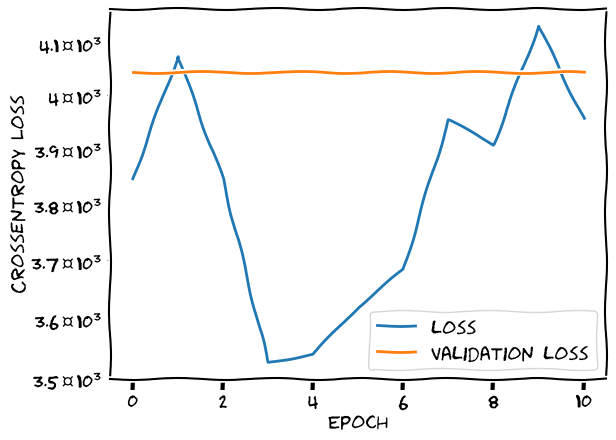

In [7]:
font = {}
import logging
# plt.style.use('dark_background')
logging.getLogger('matplotlib.font_manager').disabled = True
plt.figure()

plt.xkcd()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Crossentropy Loss')
plt.legend()
plt.show()

In [8]:
X_test[0].shape

(64, 64, 3)

In [39]:
import pickle

pickle.dump(model, open('model.pickle', 'wb'))

1/1 [==============================] - 0s 15ms/step


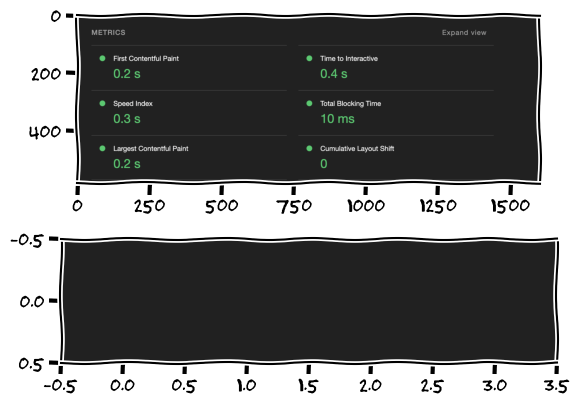

In [35]:
image_load = Image.open('image.png').convert('RGB')
fig, axes = plt.subplots(nrows=2)


# image = data['images'][1]

axes[0].imshow(image_load)
answer = model.predict(np.array([np.array(image_load)]))
axes[1].imshow(np.rint(answer).astype(np.uint8))